In [1]:
# imports
import math
import numpy as np
import pandas as pd
from scipy import stats
import random
import matplotlib.pyplot as plt
# import mayavi.mlab as mlab
import seaborn as sns

In [2]:
# todo: put all functions and code in separate files for cleanliness and readability

In [3]:
# setup default infection parameters

floor_area = 86.02  # ft2 # 11.4 m * 2.3 m * (m^2->ft^2) = 86.02 ~= 86 ft^2
mean_ceiling_height = 12  # ft # 1.85 m -> ft = 6.06 ~= 6 ft
air_exchange_rate = 20  # /hr (air changes per hour (ACH)) #moving bus mph average


##Assumed Parameter Identified as 0.2 for Classrooms, 1.0 for outdoors#
# and .5 for buses with windows open
primary_outdoor_air_fraction = 0.5  # 1.0 = natural ventilation
aerosol_filtration_eff = 0  # >0.9997 HEPA, =0.2-0.9 MERVs, =0 no filter
# bus has no filter

#Average daily RH for San Diego is 69%
relative_humidity = 0.69 
physical_params = [floor_area, mean_ceiling_height, air_exchange_rate, primary_outdoor_air_fraction,
                        aerosol_filtration_eff, relative_humidity]

# Physiological Parameters
breathing_flow_rate = 0.5  # m3/hr
max_aerosol_radius = 2  # micrometers
physio_params = [breathing_flow_rate, max_aerosol_radius]

# Disease Parameters
exhaled_air_inf = 30  # infection quanta/m3, changes with acitivity type.
max_viral_deact_rate = 0.3  # /hr
disease_params = [exhaled_air_inf, max_viral_deact_rate]

# Precautionary Parameters
mask_passage_prob = .1 # 1 = no masks, ~0.1 cloth, <0.05 N95
risk_tolerance = 0.1  # expected transmissions per infector
prec_params = [mask_passage_prob, risk_tolerance]

In [4]:
# transmission code:

def return_aerosol_transmission_rate(floor_area, room_height,
                            air_exchange_rate, 
                            aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
                            exhaled_air_inf, max_viral_deact_rate, mask_passage_prob, 
                            max_aerosol_radius=2, primary_outdoor_air_fraction=0.2):
    
    mean_ceiling_height_m = mean_ceiling_height * 0.3048 #m3
    room_vol = floor_area * mean_ceiling_height  # ft3
    room_vol_m = 0.0283168 * room_vol  # m3

    fresh_rate = room_vol * air_exchange_rate / 60  # ft3/min
    recirc_rate = fresh_rate * (1/primary_outdoor_air_fraction - 1)  # ft3/min
    air_filt_rate = aerosol_filtration_eff * recirc_rate * 60 / room_vol  # /hr
    eff_aerosol_radius = ((0.4 / (1 - relative_humidity)) ** (1 / 3)) * max_aerosol_radius
    viral_deact_rate = max_viral_deact_rate * relative_humidity
    sett_speed = 3 * (eff_aerosol_radius / 5) ** 2  # mm/s
    sett_speed = sett_speed * 60 * 60 / 1000  # m/hr
    conc_relax_rate = air_exchange_rate + air_filt_rate + viral_deact_rate + sett_speed / mean_ceiling_height_m  # /hr
    airb_trans_rate = ((breathing_flow_rate * mask_passage_prob) ** 2) * exhaled_air_inf / (room_vol_m * conc_relax_rate)
    
    return airb_trans_rate #This is mean number of transmissions per hour between pair of infected / healthy individuals



In [5]:
return_aerosol_transmission_rate(floor_area, mean_ceiling_height,
                            air_exchange_rate, 
                            aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
                            exhaled_air_inf, max_viral_deact_rate, mask_passage_prob, 
                            max_aerosol_radius=2, primary_outdoor_air_fraction=0.2)

0.00012355597877443782

In [6]:
# setup variables and functions# output graphs
# countdown until symptoms appear: probability curve
shape, loc, scale =  (0.6432659248014824, -0.07787673726582335, 4.2489459496009125)
x = np.linspace(0, 17, 1000)
countdown_curve = stats.lognorm(s=shape, loc=loc, scale=scale)

student_a_tus = int(np.round(stats.lognorm.rvs(shape, loc, scale, size=1)[0], 0))
#tus = time until symptom

# bound the days for overflow errors
if student_a_tus >= 18:
    student_a_tus = 17
if student_a_tus <= 0:
    student_a_tus = 0
print(student_a_tus)

# create infectiveness reference dataframe
shape, loc, scale = (20.16693271833812, -12.132674385322815, 0.6322296057082886)
x = np.linspace(-10, 8, 19)
infective_df = pd.DataFrame({'x': list(x), 'gamma': list(stats.gamma.pdf(x, a=shape, loc=loc, scale=scale))})

# uninfected = {i: 0 for i in uninf_index}
chu_distance_curve = 2.02
a_infectivity = infective_df.iloc[student_a_tus].gamma
print(a_infectivity)

1
1.1701572234935805e-06


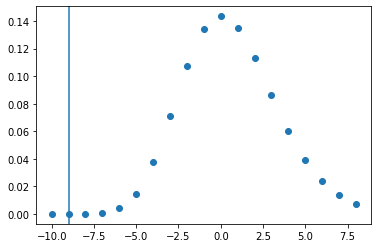

In [7]:
plt.scatter(infective_df.x, infective_df.gamma)
plt.axvline(x=infective_df.iloc[student_a_tus].x)

In [8]:
days_until_symptoms_expected = infective_df.iloc[student_a_tus].x

# for i in student_pos:
#     print(i)
print('this is the number of days until symptoms are expected (simulated infectivity): ' + str(int(-days_until_symptoms_expected)))
print('this is the resulting infectivity we expect: ' + str(a_infectivity))

this is the number of days until symptoms are expected (simulated infectivity): 9
this is the resulting infectivity we expect: 1.1701572234935805e-06


In [9]:
# 4 students: next to vs across from vs zigzag

# do 1000 runs and average: plot distributions of infection rate for each (w/ different initial # days)


who_infected = {'student_b': 0,
                'student_c': 0,
                'student_d': 0}

transmission_rates = {'student_b': [],
                'student_c': [],
                'student_d': []}

mask_rates = transmission_rates.copy()

distances = []
def get_distance(student_pos, i):
    x1, y1 = student_pos['student_a']
    x2, y2 = student_pos[i]
    return x1, x2, y1, y2

def get_dist_multiplier(distance):
    return 1 / (chu_distance_curve ** distance)


def init_positions():
    # generate size of room based on 
    positions = {'student_a': [0,0],
                'student_b': [.3, 0],
                'student_c': [1, 0],
                'student_d': [1, .5]}
    return positions 

def masks_help(adherence):
    reward = np.random.choice([.1, .5], p=[adherence, 1-adherence])
    
    return reward
    
    
    
student_pos = init_positions()


# _ b | _ d
# a _ | c _


# _ b _ | _ d _
# _ a _ | _ c _

n_model_runs = 100
    # 3 weeks * 5 days * 2 trips * 30 mins / 5 (steps/min)
for run in range(n_model_runs):
#     n_steps = 180
    for week in range(3):
        for day in range(5):
            for trip in range(2):
                
                
                for i in range(6): # 5 minutes per step * 6 steps = 30 minute trip
                    student_a_tus = int(np.round(stats.lognorm.rvs(shape, loc, scale, size=1)[0], 0))
                    #tus = time until symptom

                    # bound the days for overflow errors
                    if student_a_tus >= 18:
                        student_a_tus = 17
                    if student_a_tus <= 0:
                        student_a_tus = 0

                    a_infectivity = infective_df.iloc[student_a_tus].gamma

                    for i in student_pos.keys():
                        if i != 'student_a':
                            x1, x2, y1, y2 = get_distance(student_pos, i)
                            distance = math.sqrt(((x2-x1)**2)+((y2-y1)**2))

                            # multiply by chu
                            dist_infect = get_dist_multiplier(distance)
                            
                            masks_ = masks_help(.9)
            
                            transmission = a_infectivity * dist_infect * masks_# this is # from 0-1
                            # keep track of transmission for this student
                            transmission_rates[i].append(transmission)
                        
                            all_masks = a_infectivity * dist_infect * mask_passage_prob
                            mask_rates[i].append(all_masks)

                            if np.random.choice([True, False], p=[transmission, 1-transmission]):
            #                     print(str(i) + ' got infected')
                                who_infected[i] += 1
                # likelihood of infection per student per trip:
                
                
                
                
    # output for run
    # get likelihood of >= 1
    # 1 - (np.prod([(1 - %infection%b ), (1- %infect%c), (1- %infect%d )]))
    
            

who_infected
# plt.plot(student_pos)

{'student_b': 17, 'student_c': 6, 'student_d': 5}

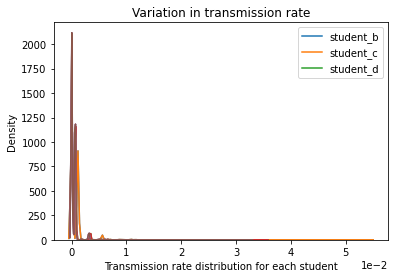

In [10]:
# get stats here
for i in student_pos.keys():
    if i != 'student_a':
        sns.kdeplot(transmission_rates[i])
        sns.kdeplot(mask_rates[i])
plt.xlabel('Transmission rate distribution for each student')
# plt.xlim(10**-2)
plt.title("Variation in transmission rate")
plt.legend(['student_b', 'student_c', 'student_d'])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.show()


# now plot % chance of >= 1 being infected
# run model 1000 times
# plot eachc % in hist w bin 10

# plt.savefig("demo_masks_vs_none.png", dpi=300)


In [11]:
def chance_of_nonzero(positions, t_rates):
    temp_array = []
    count = 0
    for i in student_pos.keys():
        if i != 'student_a':
            for j in transmission_rates[i]:
                temp_array.append(1-j)
                count += 1
    return np.product(temp_array), count
chance_of_nonzero(student_pos, transmission_rates)

(7.954994153178914e-23, 108000)

In [12]:
mask_rates

{'student_b': [0.0011178116661121498,
  0.0011178116661121498,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.005589058330560749,
  0.0011178116661121498,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.005589058330560749,
  0.0011178116661121498,
  1.4515583283226813e-09,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.001117811

{'student_b': 0.0012946978720191908, 'student_c': 0.0007969915120046691, 'student_d': 0.0007310984299038553}


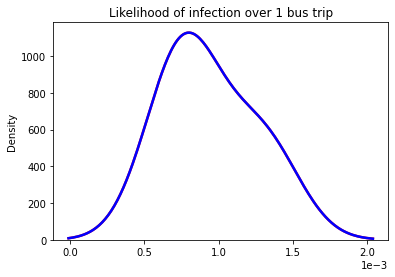

In [13]:
temp = transmission_rates
new_temp = mask_rates
sum_rates = {i: sum(new_temp[i]) / (n_model_runs * 180) for i in new_temp}
# print(sum_rates)
sns.kdeplot(sum_rates, linewidth=2.5, c="Red")

one_trip_rate = {i: sum(temp[i]) / (n_model_runs * 180) for i in temp}
sns.kdeplot(one_trip_rate, linewidth=2.5, c="Blue")
plt.title('Likelihood of infection over 1 bus trip')

plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


plt.savefig("demo_bus_trip_infection.png", dpi=300)

print(one_trip_rate)

In [14]:
transmission_rates

{'student_b': [0.0011178116661121498,
  0.0011178116661121498,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.005589058330560749,
  0.0011178116661121498,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.0011178116661121498,
  2.903116656645363e-10,
  2.903116656645363e-10,
  0.005589058330560749,
  0.0011178116661121498,
  1.4515583283226813e-09,
  2.903116656645363e-10,
  0.0011178116661121498,
  0.001117811

In [15]:
# initialize bus 
def init_positions_bus():
    #
    positions = {'a': [2, 3],
                'b': [2, 16],
                'c': [9, 8],
                'd': [9, 21],
                'e': [16, 3],
                'f': [16, 16],
                'g': [23, 8],
                'h': [23, 21],
                'i': [30, 3],
                'j': [30, 16],
                'k': [37, 8],
                'l': [37, 21],
                'm': [44, 3],
                'n': [44, 16],
                'o': [51, 8],
                'p': [51, 21],
                'q': [58, 3],
                'r': [58, 16],
                's': [65, 8],
                't': [65, 21],
                'u': [72, 3],
                'v': [72, 16],
                'w': [79, 8],
                'x': [79, 21],
                'y': [86, 3],
                'z': [86, 16],
                'aa': [93, 8],
                'ab': [93, 21]}
    return positions

# add height? X, Y gives a top down 2d plot
def init_flow_student_locations():
    locations = {'a': [1, 1],
                'b': [1, 4],
                'c': [2, 2],
                'd': [2, 5],
                'e': [3, 1],
                'f': [3, 4],
                'g': [5, 2],
                'h': [5, 5],                
                'i': [6, 1],
                'j': [6, 4],
                'k': [7, 2],
                'l': [7, 5],                
                'm': [9, 1],
                'n': [9, 4],
                'o': [10, 2],
                'p': [10, 5],                
                'q': [12, 1],
                'r': [12, 4],
                's': [13, 2],
                't': [13, 5],                
                'u': [14, 1],
                'v': [14, 4],
                'w': [16, 2],
                'x': [16, 5],                
                'y': [17, 1],
                'z': [17, 4],
                'aa': [18, 2],
                'ab': [18, 5]}
    return locations

def get_distance_bus(bus_pos, i, initial):
    x1, y1 = bus_pos[initial]
    x2, y2 = bus_pos[i]
    return x1, x2, y1, y2

def air_flow_infect(student_id):
    # this applies airflow to aerosol %
    # TODO: step by step airflow
    
    # use quiver mapping at bottom- fix that firstx
    
    x, y = bus_flow_loc[student_id]  
    return temp_array[5][x][y]


In [16]:
# bus_flow_loc

NameError: name 'bus_flow_loc' is not defined

In [ ]:
# Visualization for air-flow quanta calculations


temp, initial = make_new_heat(nothings)

# simulate all #s over 1000 runs
# average all points

# plt.matshow(out)
range_ = 25
temp_array = []

for i in range(range_): # this heatmap displays average risk / 1000 sample runs
    temp, initial = make_new_heat(temp, initial)
#     plt.matshow(temp, cmap="Reds")
    temp_array.append(temp)
    
plt.matshow(temp_array[-1], cmap="Reds")
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)


plt.savefig("contagion_step_10.png", dpi=300) # set savefig in for loop


In [ ]:
bus_pos = init_positions_bus()
who_infected_bus = {'a': 0,
                   'b': 0,
                   'c': 0,
                   'd': 0,
                   'e': 0,
                   'f': 0,
                   'g': 0,
                   'h': 0,
                   'i': 0,
                   'j': 0,
                   'k': 0,
                   'l': 0,
                   'm': 0,
                   'n': 0,
                   'o': 0,
                   'p': 0,
                   'q': 0,
                   'r': 0,
                   's': 0,
                   't': 0,
                   'u': 0,
                   'v': 0,
                   'w': 0,
                   'x': 0,
                   'y': 0,
                   'z': 0,
                   'aa': 0,
                   'ab': 0,}
transmission_bus_rates = {i: [] for i in who_infected_bus.keys()}
temp_rates = transmission_bus_rates.copy()

aqd = return_aerosol_transmission_rate(floor_area, mean_ceiling_height,
                            air_exchange_rate, 
                            aerosol_filtration_eff, relative_humidity, breathing_flow_rate,
                            exhaled_air_inf, max_viral_deact_rate, mask_passage_prob, 
                            max_aerosol_radius=2, primary_outdoor_air_fraction=0.2)
all_masked = transmission_bus_rates.copy()
n_runs = 100
# for init_choice in ['a']:
for i in range(n_runs):
    init_choice = np.random.choice(list(who_infected_bus.keys()))
    for trip in range(2):
        temp_average_array = temp_rates.copy()
        temp_mask_array = temp_rates.copy()

        for five_min_timestep in range(6):
            # set initial infected TODO change from always 'a' (in the back)
            initial = init_choice
            student_a_tus = int(np.round(stats.lognorm.rvs(shape, loc, scale, size=1)[0], 0))
            #tus = time until symptom

            # bound the days for overflow errors
            if student_a_tus >= 18:
                student_a_tus = 17
            if student_a_tus <= 0:
                student_a_tus = 0

            a_infectivity = infective_df.iloc[student_a_tus].gamma

            for i in bus_pos.keys():
                if i != init_choice:
                    x1, x2, y1, y2 = get_distance_bus(bus_pos, i, initial)
                    distance = math.sqrt(((x2-x1)**2)+((y2-y1)**2))

                    # multiply by chu
                    dist_infect = get_dist_multiplier(distance)
#                     print(dist_infect)
                else:
                    dist_infect = 1
                air = i
                air_flow = air_flow_infect(i)

                aerosol_quanta_dose = aqd
                
                mask_adherence = .8
                temp = np.random.choice([.1, .5], p=[mask_adherence, 1.0 - mask_adherence])

                transmission = (a_infectivity * dist_infect * temp) + (aerosol_quanta_dose * air_flow)# this is # from 0-1
#                     print(transmission)
#                         transmission_bus_rates[i].append(transmission)
                mask_trans = (a_infectivity * dist_infect * mask_passage_prob) + (aerosol_quanta_dose * air_flow)
                temp_average_array[i].append(transmission)
                temp_mask_array[i].append(mask_trans)



                if np.random.choice([True, False], p=[transmission, 1-transmission]):
#                         print(str(i) + ' got infected')
                    who_infected_bus[i] += 1
        # likelihood of infection for each student for each trip
        for i in bus_pos.keys():
#                 if i != init_choice:
            transmission_bus_rates[i].append(np.mean(temp_average_array[i]))
            all_masked[i].append(np.mean(temp_mask_array[i]))
            
# take average of all % infections for each student
# transmission_bus_rates['x']
who_infected_bus

In [ ]:
# this function embodies the air flow's reduction of viral particles at each step according to observations and simulations
# Turbulence creates unequal concentrations within the environment, resulting in open windows and ceiling vents 
# being primary contributors to reduction of viral particles

bus_flow_direction = np.array([[1, 1, 1, 2, 3, 4, 4],
              [1, 4, 7, 8, 9, 9, 6],
              [4, 7, 7, 8, 9, 9, 6],
              [4, 4, 5, 2, 5, 4, 4],
              [8, 5, 5, 2, 5, 5, 8], #
              [1, 1, 1, 2, 5, 6, 6],
              [1, 1, 2, 2, 5, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [5, 5, 5, 2, 5, 5, 5],
              [1, 1, 1, 2, 3, 3, 3], #
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 1, 2, 2, 2, 3, 3],
              [1, 5, 5, 2, 2, 3, 3], #
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 2, 3, 3],
              [1, 1, 1, 2, 3, 6, 6],
              [1, 1, 2, 2, 3, 3, 6],
              [1, 2, 2, 2, 3, 3, 6], #
              [4, 4, 4, 5, 6, 6, 6],
              [2, 2, 2, 5, 5, 5, 5],
              [2, 2, 5, 8, 2, 2, 2]])

bus_flow_velocity = np.array([[3,3,2,1,1,0,1],
    [1,0,1,2,3,2,2],
    [1,2,1,0,1,2,2],
    [2,1,0,0,0,1,1],
    [2,1,0,0,0,1,1], #
    [2,1,0,0,0,0,1],
    [1,1,0,0,0,0,1],
    [1,2,1,1,0,0,0],
    [0,1,2,1,0,1,2],
    [0,0,0,0,0,0,1], #
    [2,2,2,2,2,1,1],
    [3,2,2,2,2,2,2],
    [2,0,0,0,0,1,2],
    [1,2,2,2,2,2,1],
    [1,1,2,2,2,1,1], #
    [1,1,2,2,2,1,1],
    [1,1,1,1,1,1,1],
    [2,2,2,2,2,2,2],
    [2,2,3,3,3,2,2],
    [1,1,2,2,2,1,1], #
    [1,1,2,2,2,1,1],
    [1,1,1,1,1,1,1],
    [1,1,1,1,0,0,0],
    [1,1,0,0,0,0,0]])

estimated_bus_risk = np.array([[1, 1, 2, 2, 2, 1, 1],
              [1, 2, 1, 3, 2, 4, 2],
              [2, 1, 1, 4, 3, 3, 2],
              [4, 3, 5, 3, 4, 4, 4],
              [3, 4, 3, 4, 2, 4, 5], #
              [3, 1, 1, 4, 5, 6, 6],
              [2, 1, 2, 5, 5, 6, 6],
              [1, 1, 2, 5, 3, 3, 6],
              [3, 5, 5, 5, 4, 6, 5],
              [1, 1, 1, 4, 3, 3, 3], #
              [1, 1, 2, 4, 2, 4, 2],
              [1, 1, 2, 4, 2, 3, 3],
              [1, 1, 2, 4, 5, 2, 1],
              [1, 1, 2, 5, 4, 3, 3],
              [2, 5, 5, 5, 3, 3, 3], #
              [1, 1, 1, 4, 3, 3, 3],
              [2, 1, 1, 5, 4, 5, 3],
              [1, 1, 1, 4, 3, 3, 6],
              [1, 2, 4, 5, 3, 4, 2],
              [1, 2, 3, 4, 4, 3, 2], #
              [3, 2, 3, 5, 4, 3, 2],
              [2, 2, 2, 4, 5, 5, 5],
              [2, 2, 5, 4, 2, 2, 2]])

# these are values relating to quanta in vs out in these .3 by .5 m squares of a slice from mouth level of the bus


# organized like:
# 3 6 9
# 2 5 8
# 1 4 7

direction_dict = {1: [9, 6, 8, 3, 7],
                 4: [8, 7, 9, 4, 6],
                 7: [7, 4, 8, 1, 9],
                 2: [6, 9, 3, 8, 2],
                 5: [0, 0, 0, 0, 0],
                 8: [4, 1, 7, 2, 8],
                 3: [3, 2, 6, 1, 9],
                 6: [2, 1, 3, 4, 6],
                 9: [1, 2, 4, 3, 7]} # these values are in .5 * risk, .05 * risk, and .125 * risk respectively
# .5, .05, .125 derived from cubic air flow direction

risk_dict = {0: .5,
            1: .05,
            2: .05,
            3: .0125,
            4: .0125} # created for access

magnitude_dict = {0: 1,
                 1: .75,
                 2: .5} # amount of quanta remaining after ventilation


def get_neighbor_incoming(x, y, old):
    neighb = []
    count = 0
    # flower petal arrow assumption:
    # if arrow = directly towards, 50% of quanta will go from neighbor -> selected
    # 
    
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            count += 1
            try:
                direction = bus_flow_direction[x + i][y + j]
                magnitude = bus_flow_velocity[x + i][y + j]
                value = old[x + i][y + j]
                this_val = old[x][y]
                this_mag = bus_flow_velocity[x][y]
                
                idx = direction_dict[count].index(direction)                
                this_val += (risk_dict[idx] * (magnitude + .1) * value) 
                new_val = this_val * magnitude_dict[this_mag]
                neighb.append(new_val)
            except:
                neighb.append(0)
    return neighb
                
                

def air_effects(i, j, oldQ):
    '''
    i, j: x y locations
    
    oldQ: old quanta at that cube
    
    
    get neighbors directions and magnitude
    determine % in and % out    
    '''
    # bus seats ?
    
    
    
    
    # windows 
    if j < 2 or j > 4:
        new = oldQ * .85
        
        
    # ceiling vents
    if (i > 6 and i < 9) or (i > 12 and i < 15):
        new = oldQ * .6
    else:
        new = 1.1 * oldQ
    
    return new

bus_flow_loc = init_flow_student_locations()

def make_new_heat(old, init_infected_ = None):
    if init_infected_:
        pass
    else:
        init_infected_ = np.random.choice(list(bus_flow_loc.keys()))
    initial_loc = bus_flow_loc[init_infected_]
    new = old.copy()
    out = old.copy()
    for i in range(len(old)):
        for j in range(len(old[i])):
#             print(i, j)
            dist = math.sqrt(((initial_loc[0] - i)**2) + (initial_loc[1] - j)**2)
            new_val = old[i][j] + (1/(2.02 ** dist))
            new[i][j] = new_val
            
            ##################################################
    for i in range(len(old)):
        for j in range(len(old[i])):
            neighbor_val = np.mean(get_neighbor_incoming(i, j, new))
            air_val = air_effects(i, j, neighbor_val)
            out[i][j] = air_val
            
#     for student in bus_flow_loc.keys():
#         location = bus_flow_loc[student]        
#         neighbor_val = np.mean(get_neighbor_incoming(x, y, old))
#         new[location[0], location[1]] = air_val
    return out, init_infected_
nothings = np.zeros(bus_flow_direction.shape)
# out, initial_ = make_new_heat(estimated_bus_risk,)
# plt.matshow(out)

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

In [ ]:
for i in temp_array:
    print(np.mean(i))
plt.plot([np.mean(i) for i in temp_array], linewidth=2.5, c='Green')
plt.xticks(np.arange(0, 6, 1), ['0', '5', '10', '15', '20', '25'])
plt.xlabel('Minutes')
plt.ylabel('Average Conc. of Virus')
plt.title('Variation of Mean Concentration over time')

plt.savefig("One_trip_concentration.png", dpi=300)

In [ ]:
# display transmission rates for all students
# get stats here
for i in bus_pos.keys():
    all_max = 0
    if i != 'a':
        new_m = max(transmission_bus_rates[i])
        plt.hist(transmission_bus_rates[i], bins=100)
        if new_m > all_max:
            all_max = new_m
#     print(all_max)
plt.xlabel('Transmission rate samples')
plt.ylabel('Density of samples')
plt.title('Distributions of post-processing transmission rate')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.savefig("Semester_infections.png", dpi=300)
# transmission_bus_rates

In [ ]:
temp = transmission_bus_rates.copy()
new_temp = all_masked.copy()
# print(temp)
del temp['a']
#
# 200 = 2 trips * 100 runs
bus_trip_rate = {i: sum(temp[i]) / 200 for i in temp}
sns.kdeplot(bus_trip_rate, linewidth=2.5, c='red').set_title("Likelihood of Infection during Sample Journey")


mask_trip_rate = {i: sum(new_temp[i]) / 200 for i in new_temp}
del new_temp['a']
sns.kdeplot(mask_trip_rate, linewidth=2.5, c='blue')
plt.xlabel("Transmission Rate")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(['masks 100%', 'masks 90%'])

# sample windows vs no windows using red vs blue

# windows / no windows

# masks 100% / 90%

# vents open / closed

# seating zigzag / seating anywhere 


# label x y etc
plt.savefig("trip_with_masks.png", dpi=300)
# print(np.mean(list(bus_trip_rate.values())))

# np.mean(list(bus_trip_rate.values()))

In [ ]:
# second output: 
# bus infections over:

# Actual bus trip [bus route ]

# 3d viz of infective areas = #stackoverflow code

In [ ]:
# original code credit: mpl.org 3dquiver tutorial
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# TODO: change to .1 spacing once gridding is correct
x, y, z = np.meshgrid(np.arange(0, 11.4, .5),
                       np.arange(0, 2.3, .5),
                       np.arange(0, 1.8, .5))


# these point in exact xyz for each point
# fix to equation 


# get x, y, z arrows from dict with  each x, y, and z:
# i.e. x_arow = arrow_direction[x, y, z]
x_array = [] # length = same as x
y_array = [] # length = same as y
z_array = [] # length = same as z

# above arrays are created manually? from making the bus in 3d
# easy peasy just use graph paper


x_arrow = np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
y_arrow = 3 #-np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
z_arrow = 10

c = np.arctan2(x, y)
# this is the eventual heatmap values?
# velocity, magnitude = direction and arrow size
# color = 'concentration at this spot'
ax.quiver(x, y, z, x_arrow, y_arrow, z_arrow, length=.1, normalize=True, cmap='viridis')
# print(x)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.legend([x, y, z])
plt.show()
# label axes




# ok now fix this to bus dimensions:

# bus is 2.3 (x) meters wide, 1.9 (y) meters tall, and 11.4 (z) meters long

# bus is thus 19
